In [423]:
import numpy as np
from collections import defaultdict
from collections import Counter
import pymongo
from __future__ import division
import re
import matplotlib.pyplot as plt
from scipy import stats
import json

def load_mongo_db():
    client = pymongo.MongoClient()
    db = client['searchx']
    return db

In [2]:
db = load_mongo_db()
logs = db.logs

## Query Features

In [3]:
def get_queries(logs, user):
    queries = {}
    db_query = {"event": "SEARCH_QUERY", "userId": user, "meta.session": 0}
    queries[0] =  [q["meta"]['query'] for q in logs.find(db_query)]
    for i in range(1,10):
        db_query = {"event": "SEARCH_QUERY", "userId": user, "meta.session": str(i)}
        queries[i] =  [q["meta"]['query'] for q in logs.find(db_query)]
    return queries



def number_queries(logs, user):
    queries = get_queries(logs, user)
    return dict(enumerate([len(queries[k]) for k in queries]))

def average_query_length(logs, user):
    queries = get_queries(logs, user)
    aql = {}
    for k in queries:
        if len(queries[k])!=0:
            aql[k] = np.mean([len(q.strip().split(" ")) for q in queries[k] ])
        else:
            aql[k] = 0
    return aql

In [17]:
get_queries(logs, "5d8d0decf345720017634bc0")

{0: [u'radioactivity', u'how radioactivity happens'],
 1: [u'radioactivity study',
  u'types of radioactivity ',
  u'radioactivity and chemo'],
 2: [u'radioactivity and cancer'],
 3: [u'coulom barrier', u'radioactive decay'],
 4: []}

In [100]:
number_queries(logs, "5d8d0decf345720017634bc0")

{0: 2, 1: 3, 2: 1, 3: 2, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

In [54]:
average_query_length(logs, "5d8d0decf345720017634bc0")

{0: 2.0, 1: 2.6666666666666665, 2: 3.0, 3: 2.0, 4: 0}

## Click and Bookmark Features

In [4]:
def number_clicks(logs, user):
    events  = ["SEARCHRESULT_CLICK_URL", "SEARCHRESULT_CONTEXT_URL"]
    clicks = {}
    db_query = {"event": {"$in":  events}, "userId": user, "meta.session": 0}
    clicks[0] =  [d for d in logs.find(db_query)]
    for i in range(1,10):
        db_query = {"event": {"$in":  events}, "userId": user, "meta.session": str(i)}
        clicks[i] = [d for d in logs.find(db_query) ]
    return dict(enumerate([len(clicks[k]) for k in clicks]))


def number_clicks_per_query(logs, user):
    events  = ["SEARCHRESULT_CLICK_URL", "SEARCHRESULT_CONTEXT_URL"]
    pages = {}
    db_query = {"event": {"$in":  events}, "userId": user, "meta.session": 0}
    pages[0] = [d["meta"]["query"] for d in logs.find(db_query)]
    pages[0] = [q for q in pages[0]]
    for i in range(1,10):
        db_query = {"event": {"$in":  events}, "userId": user, "meta.session": str(i)}
        pages[i] = [d["meta"]["query"] for d in logs.find(db_query)]
        pages[i] = [q for q in pages[i]]
        
    tmp = []
    for j in range(10):
        if len(pages[j]) == 0:
            tmp.append(0)
        else:
            counter = Counter(pages[j])
            tmp.append(np.mean(list(counter.values())))
    return dict(enumerate(tmp))

def number_clicks_per_all_query(logs, user):
    events  = ["SEARCHRESULT_CLICK_URL", "SEARCHRESULT_CONTEXT_URL"]
    total_queries = number_queries(logs, user)
    clicks = {}
    db_query = {"event": {"$in":  events}, "userId": user, "meta.session": 0}
    clicks[0] = [d for d in logs.find(db_query)]
    
    for i in range(1,10):
        db_query = {"event": {"$in":  events}, "userId": user, "meta.session": str(i)}
        clicks[i] = [d for d in logs.find(db_query)]
        
    tmp = []
    for j in range(10):
        if total_queries[j] == 0:
            tmp.append(0)
        else:
            tmp.append(round(len(clicks[j])/total_queries[j], 5))
    return dict(enumerate(tmp))

def number_bookmarks(logs, user):
    events  = ["BOOKMARK_ACTION"]
    bookmarks = {}
    db_query = {"event": {"$in":  events}, "userId": user, "meta.session": 0}
    bookmarks[0] = [ d["meta"]["url"] for d in logs.find(db_query)]
    for i in range(1,10):
        db_query = {"event": {"$in":  events}, "userId": user, "meta.session": str(i)}
        bookmarks[i] = [d["meta"]["url"] for d in logs.find(db_query) ]
    return dict(enumerate([len(bookmarks[k]) for k in bookmarks]))

In [98]:
number_clicks_per_query(logs,"5d8d0decf345720017634bc0")

{0: 1.0, 1: 1.5, 2: 3.0, 3: 1.0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

In [115]:
number_clicks_per_all_query(logs,"5d8d0decf345720017634bc0")

{0: 1.0, 1: 1.0, 2: 3.0, 3: 0.5, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

In [103]:
number_queries(logs, "5d8d0decf345720017634bc0")

{0: 2, 1: 3, 2: 1, 3: 2, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

In [82]:
number_clicks(logs, "5d8d0decf345720017634bc0")

{0: 2, 1: 3, 2: 3, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

In [121]:
number_bookmarks( logs,"5d8d0decf345720017634bc0")

{0: 0, 1: 4, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

## Document Features


In [5]:
def number_views(logs, user):
    pages = {}
    db_query = {"event": "DOCUMENT_LOAD", "userId": user, "meta.session": 0}
    pages[0] = [d['meta']['url'] for d in logs.find(db_query)]
    for i in range(1,10):
        db_query = {"event": "DOCUMENT_LOAD", "userId": user, "meta.session": str(i)}
        pages[i] = [d['meta']['url'] for d in logs.find(db_query)]
    return dict(enumerate([len(pages[k]) for k in pages]))


def number_views_per_query(logs, user):
    pages = {}
    db_query = {"event": "DOCUMENT_LOAD", "userId": user, "meta.session": 0}
    pages[0] = [d["meta"]["query"] for d in logs.find(db_query) ]
    pages[0] = [q for q in pages[0]]
    for i in range(1,10):
        db_query = {"event": "DOCUMENT_LOAD", "userId": user, "meta.session": str(i)}
        pages[i] = [d["meta"]["query"] for d in logs.find(db_query)]
        pages[i] = [q for q in pages[i]]
        
    tmp = []
    for j in range(10):
        if len(pages[j]) == 0:
            tmp.append(0)
        else:
            counter = Counter(pages[j])
            tmp.append(np.mean(list(counter.values())))
    return dict(enumerate(tmp))

def number_views_per_all_query(logs, user):
    
    total_queries = number_queries(logs, user)
    pages = {}
    db_query = {"event": "DOCUMENT_LOAD", "userId": user, "meta.session": 0}
    pages[0] = [d['meta']['url'] for d in logs.find(db_query)]
    for i in range(1,10):
        db_query = {"event": "DOCUMENT_LOAD", "userId": user, "meta.session": str(i)}
        pages[i] = [d['meta']['url'] for d in logs.find(db_query)]
        
    tmp = []
    for j in range(10):
        if total_queries[j] == 0:
            tmp.append(0)
        else:
            tmp.append(round(len(pages[j])/total_queries[j], 5))
    return dict(enumerate(tmp))

def get_dwelltime(logs, user, session):
    dwelltime = []
    for d in logs.find({"event": "DOCUMENT_LOAD", "userId": user, "meta.session": session}):
        docid = d["meta"]["url"]
        t_start = d["date"]
        
        close_event = logs.find_one({"event": "DOCUMENT_CLOSE",
                                    "userId": user, "meta.url": docid, "date" : {"$gte": t_start}})
        if close_event == None:
            dwelltime.append(0.0)
            continue
        viewed_time = close_event["date"] - t_start
        dwelltime.append(viewed_time.seconds)
        
    if len(dwelltime) == 0:
        return 0.0
    return dwelltime

def total_document_dwelltime(logs, user):
    
    dwell = {}
    dwell[0] = np.sum(get_dwelltime(logs, user, 0))
    for i in range(1,10):
        dwell[i] = np.sum(get_dwelltime(logs, user, str(i)))
    
    return dwell
        

def avg_document_dwelltime(logs, user):
    avg_dwell = {}
    avg_dwell[0] = np.mean(get_dwelltime(logs, user, 0))
    for i in range(1,10):
        avg_dwell[i] = np.mean(get_dwelltime(logs, user, str(i)))
    
    return avg_dwell


def avg_document_dwelltime_per_query(logs, valid_queries, user, topic, time):
    time_start, time_end = time
    date = {"$lte" : time_end, "$gt": time_start}
    dwelltime = defaultdict()
    for d in logs.find({"event": "DOCUMENT_LOAD", "userId": user, "date": date}):
        docid = d["meta"]["url"]
        if "query" not in d["meta"] and d["meta"]["query"] not in valid_queries:
            continue
        query =  d["meta"]["query"]
        if query not in dwelltime:
            dwelltime[query] = 0.0
        t_start = d["date"]
        topicId = d["sessionId"].split("-")[1]
        if topicId != topic:
            continue
        close_event = logs.find_one({"event": "DOCUMENT_CLOSE",
                                    "userId": user, "meta.url": docid, "date" : {"$gte": t_start}})
        if close_event == None:
            continue
        viewed_time = close_event["date"] - t_start
        dwelltime[query] +=  viewed_time.seconds
    if len(dwelltime):
        return  np.mean(list(dwelltime.values()))
    return 0.0

def total_document_scrolls(logs, user):
    events  = ["DOCUMENT_SCROLL"]
    scroll = {}
    db_query = {"event": {"$in":  events}, "userId": user, "meta.session":0}
    scroll[0] = [ q["meta"]["url"] for q in logs.find(db_query) ]
    for i in range(1,10):
        db_query = {"event": {"$in":  events}, "userId": user, "meta.session": str(i)}
        scroll[i] = [q["meta"]["url"] for q in logs.find(db_query) ]
    return dict(enumerate([len(scroll[k]) for k in scroll]))

In [158]:
total_document_dwelltime(logs,"5d8d0decf345720017634bc0")

{0: 366, 1: 27, 2: 72, 3: 694, 4: 176, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0}

In [167]:
avg_document_dwelltime(logs,"5d8d0decf345720017634bc0")

{0: 183.0,
 1: 6.75,
 2: 24.0,
 3: 173.5,
 4: 35.2,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0}

In [137]:
number_views_per_all_query( logs,"5d8d0decf345720017634bc0")

{0: 1.0, 1: 1.33333, 2: 3.0, 3: 2.0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

In [130]:
number_views_per_query( logs,"5d8d0decf345720017634bc0")

{0: 1.0,
 1: 2.0,
 2: 3.0,
 3: 1.3333333333333333,
 4: 5.0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0}

In [131]:
number_views( logs,"5d8d0decf345720017634bc0")

{0: 2, 1: 4, 2: 3, 3: 4, 4: 5, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

## SERP FEATURES

In [51]:
def unique_domains_per_session(logs, user, i):

    db_query = {"event": "SEARCHRESULT_VIEW_URL", "userId": user, "meta.session": i}
    unique_dom = 0.0
    serp_count = 0
    for serp in np.unique([d['meta']['serpId'] for d in logs.find(db_query)]):
        if serp:
            serp_count += 1
            dom_query = {"event": "SEARCHRESULT_VIEW_URL", "userId": user, "meta.session": i, "meta.serpId": str(serp)}
            domlist = [re.search('//(.+?)/',d['meta']['url']).group(1) for d in logs.find(dom_query)]
            if len(domlist)!=0:
                unique_dom += len(np.unique(domlist))/len(domlist)
    if serp_count == 0:
        return 0
    return unique_dom/serp_count

def unique_domains(logs, user):
    avg_domain = {}
    avg_domain[0] = unique_domains_per_session(logs, user, 0)
    for i in range(1,10):
        avg_domain[i] = unique_domains_per_session(logs, user, str(i))
    
    return avg_domain

In [52]:
unique_domains( logs,"5d8d0decf345720017634bc0")

{0: 0.875,
 1: 0.6245454545454546,
 2: 0.5145161290322581,
 3: 0.8795454545454546,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0}

In [238]:
users = ["5b587dc6efcd5c0001cebd03", "5b587dc6efcd5c0001cebd03", "57533f7c483c14000662f391", "5d3a3b28376aea001a66782d",
"5c9e5a042b3c77001544e975", "5d26f5eb7aa0b0000138b4ba", "5d0a993c6e9965001aeafe67", "5c9162220791df0001366aa6","5d4fe8e3f20feb00190b643c",
"5d63bfff79f8dc0015af6de3","5a97081189de8200013eea9b","5952a1dc27f8fb00016213bb","58fd0de6d66f6400016dc0fd",
"5c742bf8ecf82a0015630ec1",
"5caf6c27b480520012eb741b",
"5d34437867a8ff0019dc0403",
"54a7c951fdf99b7cd759d23e",
"5c3f00de1580e9000122ecb5",
"5b0f27321e55760001b9a8a5","5c864b1bd9fe700001023b72","5cacf324ea201200013d7807","5b0c5ae5641b1200010ee49d","59308b35deea010001017c0e","5c28ef690091e40001ca5e99","5bcdf10432e46700016f8f80","595022904df2c40001bf85df","5877f454127d7700018b1bdf","5bf1de1556a321000106fae0","5b09bd6ae9270900013b82be","5cd0cdf9731ab00013a73906","59f8868e05d1d60001f1464d","5b82d4fda284bc000193094c","5d91a7c336017c00192a6755","5d8e3a178b0c840017736451","59bb884a3c45a10001ccc4f7","5d235fa4c9b2ee00190ed9af","58d0632c2fc72000011f8c57","5cf1b0f475b61a0001d00408","5be89ff4d153f500019aa86f","55f244e632af740012170458","5993020a5f49420001caf86b","5b0b1b5a9663ee0001456cec","5d8d0decf345720017634bc0","5d114bdc009d5e001ac94487","5d5ba6430ffa48001b458d64","5b6c3818f458f500013774a3","5d27b8fee5af0b00157f41a6","5c3fb34812dd430001d4b4d5","5d971ac046a93c0017005bf1","5b421b9ac2e3810001763252","57843b986475d400015a8e45","5d30eee5e7ca2e001bd4091b","5c1a32c91f191b0001ebe392","5c54b2e0cf1cd900018cf6a6","5bddad5e3dad0a0001e2d79b","5c676d436f250200012a04e8","5977e3867412f8000194e1fe","5d269f7442562200018babe6","5c5cad3e4ee81200018eafe2","5d404bc74db54a0001fecb92","56cb839cedf8da000c6df35b","5a69fb84eeef45000138d276"]

In [165]:
highiq_users = ['5c9e5a042b3c77001544e975',
 '5d26f5eb7aa0b0000138b4ba',
 '5d34437867a8ff0019dc0403',
 '58d0632c2fc72000011f8c57',
 '5be89ff4d153f500019aa86f',
 '55f244e632af740012170458',
 '5d8d0decf345720017634bc0',
 '5b6c3818f458f500013774a3',
 '5c3fb34812dd430001d4b4d5',
 '5d269f7442562200018babe6',
 '5d404bc74db54a0001fecb92']
lowiq_users = ['5b587dc6efcd5c0001cebd03', '5b587dc6efcd5c0001cebd03', '57533f7c483c14000662f391', '5d3a3b28376aea001a66782d', '5d0a993c6e9965001aeafe67', '5c9162220791df0001366aa6', '5d4fe8e3f20feb00190b643c', '5d63bfff79f8dc0015af6de3', '5a97081189de8200013eea9b', '5952a1dc27f8fb00016213bb', '58fd0de6d66f6400016dc0fd', '5c742bf8ecf82a0015630ec1', '5caf6c27b480520012eb741b', '54a7c951fdf99b7cd759d23e', '5c3f00de1580e9000122ecb5', '5b0f27321e55760001b9a8a5', '5c864b1bd9fe700001023b72', '5cacf324ea201200013d7807', '5b0c5ae5641b1200010ee49d', '59308b35deea010001017c0e', '5c28ef690091e40001ca5e99', '5bcdf10432e46700016f8f80', '595022904df2c40001bf85df', '5877f454127d7700018b1bdf','5bf1de1556a321000106fae0', '5b09bd6ae9270900013b82be', '5cd0cdf9731ab00013a73906', '59f8868e05d1d60001f1464d', '5b82d4fda284bc000193094c', '5d91a7c336017c00192a6755', '5d8e3a178b0c840017736451', '59bb884a3c45a10001ccc4f7', '5d235fa4c9b2ee00190ed9af', '5cf1b0f475b61a0001d00408', '5993020a5f49420001caf86b', '5b0b1b5a9663ee0001456cec', '5d114bdc009d5e001ac94487', '5d5ba6430ffa48001b458d64', '5d27b8fee5af0b00157f41a6', '5d971ac046a93c0017005bf1', '5b421b9ac2e3810001763252', '57843b986475d400015a8e45', '5d30eee5e7ca2e001bd4091b', '5c1a32c91f191b0001ebe392', '5c54b2e0cf1cd900018cf6a6', '5bddad5e3dad0a0001e2d79b', '5c676d436f250200012a04e8', '5977e3867412f8000194e1fe', '5c5cad3e4ee81200018eafe2', '56cb839cedf8da000c6df35b','5a69fb84eeef45000138d276']

In [191]:
highiq_num_serp = {'0': [], '1': [], '2': [], '3': [], '4':[] }
lowiq_num_serp = {'0': [], '1': [], '2': [], '3': [], '4':[] }
for count, user in enumerate(highiq_users):
    print(count)
#     print(user)
#     print(dict2)
    t = unique_domains(logs,user)
    for i in range(5):
        highiq_num_serp[str(i)].append(t[i])
        
for count, user in enumerate(lowiq_users):
    print(count)
#     print(user)
#     print(dict2)
    t = unique_domains(logs,user)
    for i in range(5):
        lowiq_num_serp[str(i)].append(t[i])        

0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [84]:
print("queries", dict1)
print("clicks", dict_number_clicks)
print("bookmarks", dict_number_bookmarks)
print("views", dict_number_views)
print("avg document view time", dict_avg_document_dwelltime)
print("total document view time", dict_total_document_dwelltime)
print("avg unique domain", dict_number_views)

('queries', {0: 129, 1: 113, 2: 131, 3: 95, 4: 10, 5: 0, 6: 0, 7: 9, 8: 0, 9: 3})
('clicks', {0: 228, 1: 241, 2: 231, 3: 217, 4: 32, 5: 2, 6: 1, 7: 2, 8: 0, 9: 0})
('bookmarks', {0: 85, 1: 74, 2: 71, 3: 79, 4: 24, 5: 0, 6: 30, 7: 4, 8: 0, 9: 0})
('views', {0: 249, 1: 311, 2: 283, 3: 268, 4: 254, 5: 2, 6: 2, 7: 2, 8: 0, 9: 0})
('avg document view time', {0: 7885.5650793650775, 1: 6640.436544011544, 2: 5757.0953102453095, 3: 2938.250252525252, 4: 1843.3122694213255, 5: 90.5, 6: 42.5, 7: 48.5, 8: 0.0, 9: 0.0})
('total document view time', {0: 17966.0, 1: 19907.0, 2: 16651.0, 3: 10718.0, 4: 6595.0, 5: 181.0, 6: 85.0, 7: 97.0, 8: 0.0, 9: 0.0})
('avg unique domain', {0: 40.54472602490138, 1: 39.45644654134472, 2: 40.72354797277172, 3: 35.69228185707981, 4: 21.804052534064187, 5: 0.056074766355140186, 6: 0.1414420617745426, 7: 0.5083333333333333, 8: 0, 9: 0})


In [171]:
highiq_num_queries

{'0': [10, 4, 2, 1, 2, 2, 2, 3, 1, 1, 3],
 '1': [3, 3, 0, 0, 3, 2, 3, 4, 0, 2, 4],
 '2': [0, 2, 3, 2, 2, 1, 1, 4, 5, 4, 0],
 '3': [0, 0, 0, 1, 4, 2, 2, 2, 7, 3, 2],
 '4': [0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1]}

In [187]:
[k for k in np.sort(highiq_num_book.keys())]

['0', '1', '2', '3', '4']

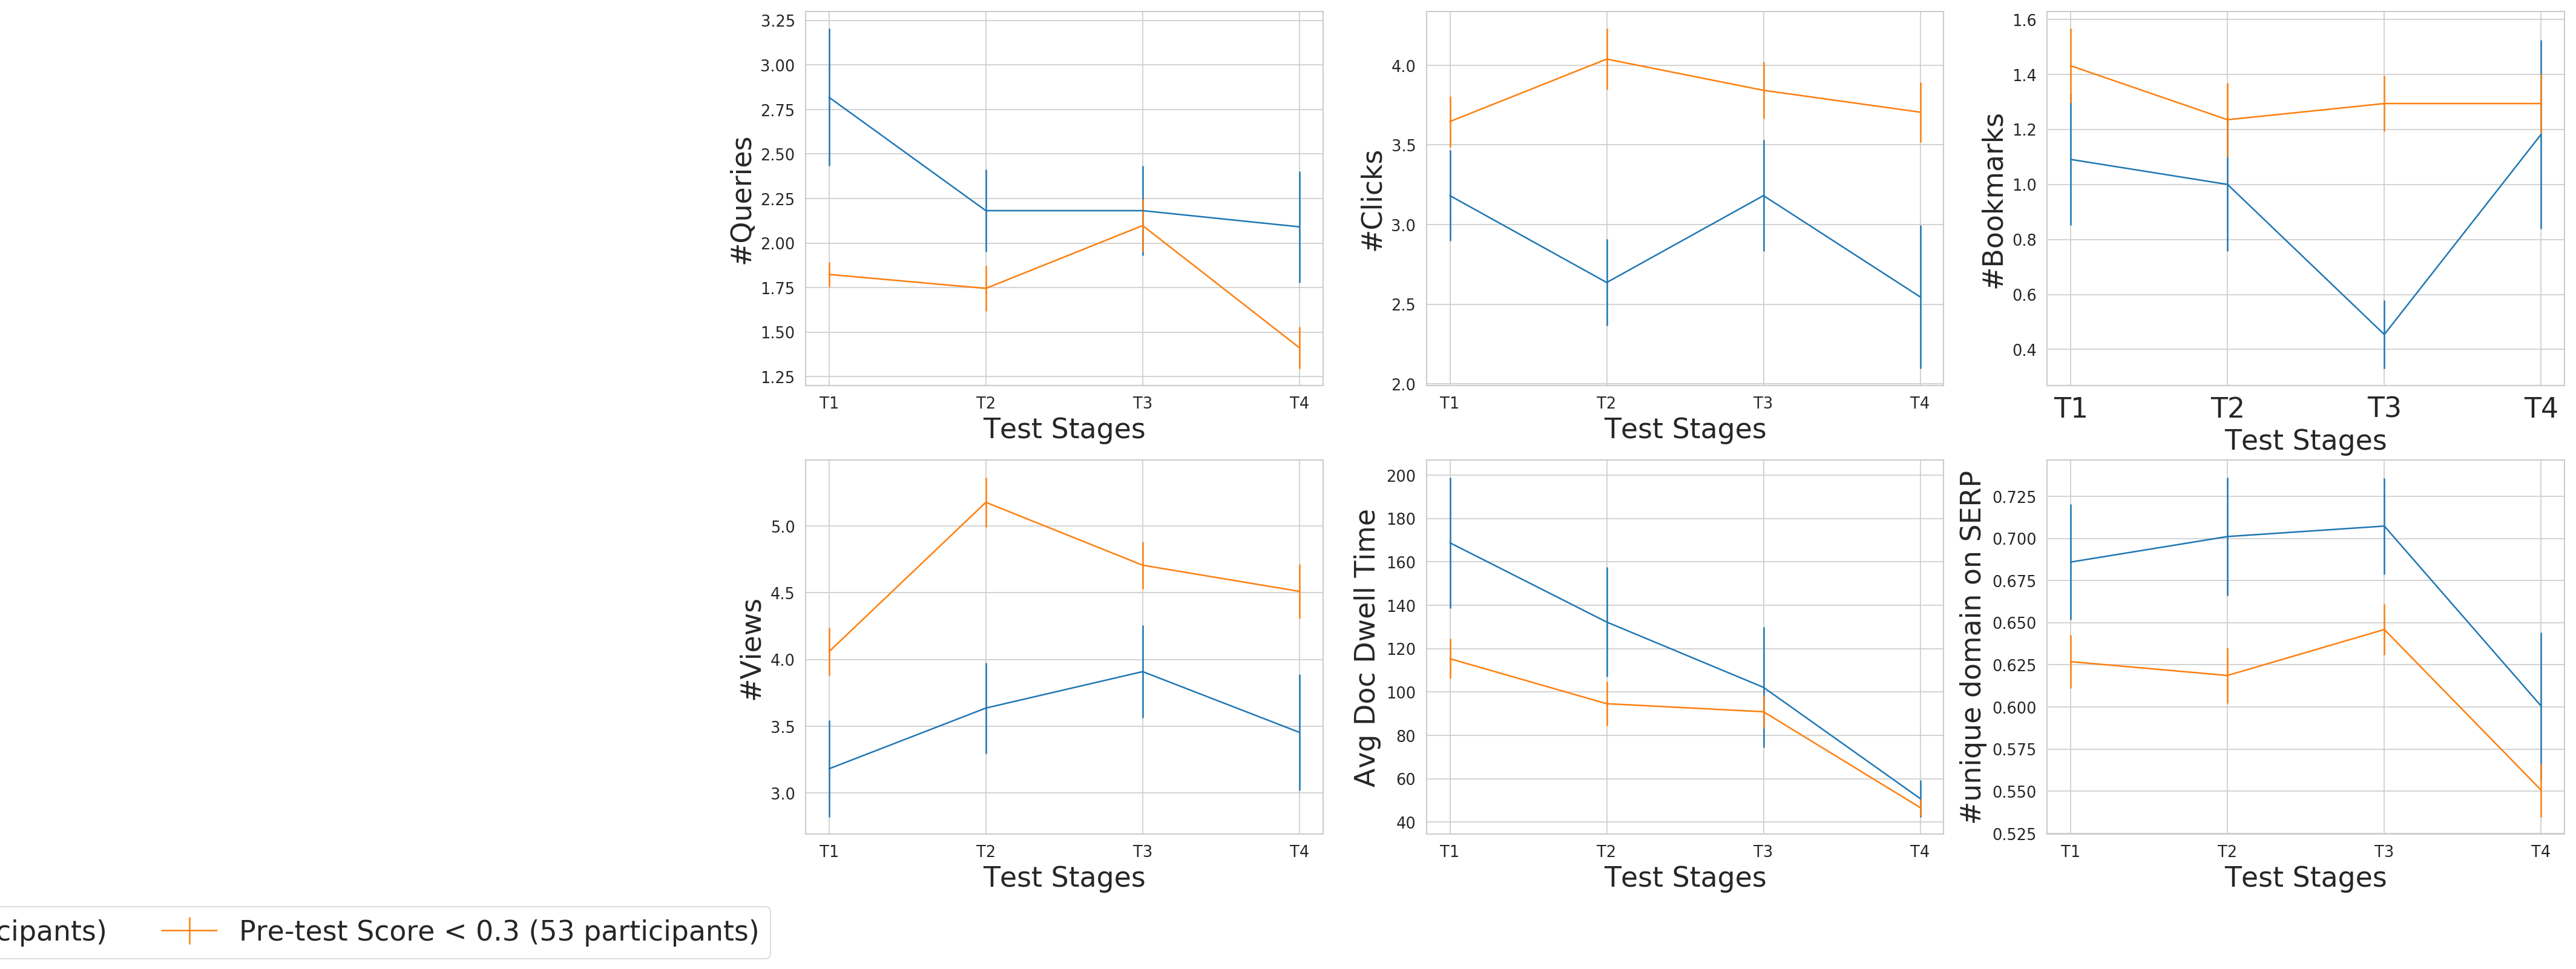

In [519]:
plt.figure(figsize=(25, 12), dpi=150)
# fig,ax = plt.subplots()
plt.subplot(2,3,1)
hq_error = [stats.sem(highiq_num_queries[k])/2 for k in np.sort(highiq_num_queries.keys())][:4]
lq_error = [stats.sem(lowiq_num_queries[k])/2 for k in np.sort(lowiq_num_queries.keys())][:4]
line1 = plt.errorbar( np.arange(4),[np.mean(highiq_num_queries[k]) for k in np.sort(highiq_num_queries.keys())][:4], hq_error )
line2 = plt.errorbar(np.arange(4), [np.mean(lowiq_num_queries[k]) for k in np.sort(lowiq_num_queries.keys())][:4],lq_error )
# plt.legend(loc='lower left', frameon=False)
plt.ylabel("#Queries", fontsize=22)
plt.xlabel("Test Stages", fontsize=22)
plt.xticks(np.arange(4), ('T1', 'T2', 'T3', 'T4'))
# plt.yaxis.set_major_locator(ticker.MultipleLocator(0.25))
# plt.legend((line1, line2), ("PTS >= 3 (11 users)", "PTS <3 (53 users)"), loc='upper right')
plt.legend((line1, line2), ("Pre-test Score $\geq 0.3$  (11 participants)", "Pre-test Score < 0.3 (53 participants)"),
           bbox_to_anchor=(3,-0.02), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3, prop={'size': 22})

plt.subplot(2,3,2)
hc_error = [stats.sem(highiq_num_clicks[k])/2 for k in np.sort(highiq_num_clicks.keys())][:4]
lc_error = [stats.sem(lowiq_num_clicks[k])/2 for k in np.sort(lowiq_num_clicks.keys())][:4]
line1 = plt.errorbar( np.arange(4),[np.mean(highiq_num_clicks[k]) for k in np.sort(highiq_num_clicks.keys())][:4], hc_error )
line2 = plt.errorbar(np.arange(4), [np.mean(lowiq_num_clicks[k]) for k in np.sort(lowiq_num_clicks.keys())][:4],lc_error )
# plt.legend(loc='lower left', frameon=False)
plt.ylabel("#Clicks", fontsize=22)
plt.xlabel("Test Stages", fontsize=22)
plt.xticks(np.arange(4), ('T1', 'T2', 'T3', 'T4'))
# plt.legend((line1, line2), ("PTS >= 3 (11 users)", "PTS <3 (53 users)"), loc='upper right')

plt.subplot(2,3,3)
hb_error = [stats.sem(highiq_num_book[k])/2 for k in np.sort(highiq_num_book.keys())][:4]
lb_error = [stats.sem(lowiq_num_book[k])/2 for k in np.sort(lowiq_num_book.keys())][:4]
line1 = plt.errorbar( np.arange(4),[np.mean(highiq_num_book[k]) for k in np.sort(highiq_num_book.keys())][:4], hb_error )
line2 = plt.errorbar(np.arange(4), [np.mean(lowiq_num_book[k]) for k in np.sort(lowiq_num_book.keys())][:4],lb_error )
# plt.legend(loc='lower left', frameon=False)
plt.ylabel("#Bookmarks", fontsize=22)
plt.xlabel("Test Stages", fontsize=22)
plt.xticks(np.arange(4), ('T1', 'T2', 'T3', 'T4'), fontsize=22)
# plt.legend((line1, line2), ("PTS >= 3 (11 users)", "PTS <3 (53 users)"), loc='upper right')

plt.subplot(2,3,4)
hv_error = [stats.sem(highiq_num_view[k])/2 for k in np.sort(highiq_num_view.keys())][:4]
lv_error = [stats.sem(lowiq_num_view[k])/2 for k in np.sort(lowiq_num_view.keys())][:4]
line1 = plt.errorbar( np.arange(4),[np.mean(highiq_num_view[k]) for k in np.sort(highiq_num_view.keys())][:4], hv_error )
line2 = plt.errorbar(np.arange(4), [np.mean(lowiq_num_view[k]) for k in np.sort(lowiq_num_view.keys())][:4],lv_error )
# plt.legend(loc='lower left', frameon=False)
plt.ylabel("#Views", fontsize=22)
plt.xlabel("Test Stages", fontsize=22)
plt.xticks(np.arange(4), ('T1', 'T2', 'T3', 'T4'))
# plt.legend((line1, line2), ("PTS >= 3 (11 users)", "PTS <3 (53 users)"), loc='upper right')

plt.subplot(2,3,5)
hd_error = [stats.sem(highiq_num_dwell[k])/2 for k in np.sort(highiq_num_dwell.keys())][:4]
ld_error = [stats.sem(lowiq_num_dwell[k])/2 for k in np.sort(lowiq_num_dwell.keys())][:4]
line1 = plt.errorbar( np.arange(4),[np.mean(highiq_num_dwell[k]) for k in np.sort(highiq_num_dwell.keys())][:4], hd_error )
line2 = plt.errorbar(np.arange(4), [np.mean(lowiq_num_dwell[k]) for k in np.sort(lowiq_num_dwell.keys())][:4],ld_error )
# plt.legend(loc='lower left', frameon=False)
plt.ylabel("Avg Doc Dwell Time", fontsize=22)
plt.xlabel("Test Stages", fontsize=22)
plt.xticks(np.arange(4), ('T1', 'T2', 'T3', 'T4'))
# plt.legend((line1, line2), ("PTS >= 3 (11 users)", "PTS <3 (53 users)"), loc='upper right')

plt.subplot(2,3,6)
hs_error = [stats.sem(highiq_num_serp[k])/2 for k in np.sort(highiq_num_serp.keys())][:4]
ls_error = [stats.sem(lowiq_num_serp[k])/2 for k in np.sort(lowiq_num_serp.keys())][:4]
line1 = plt.errorbar( np.arange(4),[np.mean(highiq_num_serp[k]) for k in np.sort(highiq_num_serp.keys())][:4], hs_error )
line2 = plt.errorbar(np.arange(4), [np.mean(lowiq_num_serp[k]) for k in np.sort(lowiq_num_serp.keys())][:4],ls_error )
# plt.legend(loc='lower left', frameon=False)
plt.ylabel("#unique domain on SERP", fontsize=22)
plt.xlabel("Test Stages", fontsize=22)
plt.xticks(np.arange(4), ('T1', 'T2', 'T3', 'T4'))
# plt.legend((line1, line2), ("PTS >= 3 (11 users)", "PTS <3 (53 users)"), loc='upper right')
plt.savefig("abs.pdf")

In [83]:
dict_unique_domains = {}
for count, user in enumerate(users):
    print(count)
#     print(user)
#     print(dict2)
    dict2 = unique_domains(logs, user)
    dict3 = {key: dict_unique_domains.get(key, 0) + dict2.get(key, 0)
          for key in set(dict_unique_domains) | set(dict2)}
    dict_unique_domains = dict3

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


In [155]:
book_stat_dict = {u'Anesthesia':[], u'Depression':[], u'Glycolysis': [],u'Industrial biotechnology':[],
                  u'Qubit': [],u'Radioactive decay': [], u'Religions': [], u'Sedimentary rocks': [], u'Urban water cycle': [],
                  u'Water quality chemistry': []}
for count, user in enumerate(users):
    print(count)
    db_query = {"event": "SEARCH_QUERY", "userId": user, "meta.session": 0}
    queries =  [q["task"]['data']['topic']['title'] for q in logs.find(db_query)]
    book_stat_dict[np.unique(queries)[0]].append(np.sum(number_bookmarks(logs, user).values()))




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


In [156]:
book_stat_dict

{u'Anesthesia': [8, 8, 16, 6, 0, 4, 0],
 u'Depression': [2, 5, 9],
 u'Glycolysis': [4, 0, 4, 0, 5, 4, 3, 6, 10, 2],
 u'Industrial biotechnology': [4, 14, 0],
 u'Qubit': [14, 7, 6, 8, 4],
 u'Radioactive decay': [0, 6, 6, 14, 9, 4, 2],
 u'Religions': [3, 7, 2],
 u'Sedimentary rocks': [0, 4, 11, 0, 4, 2],
 u'Urban water cycle': [9, 11, 9, 0, 7, 4],
 u'Water quality chemistry': [12, 0, 4, 6, 1, 2, 2, 34, 13, 5, 16, 3, 2, 0]}

In [159]:
avg_query_per_topic

{u'Anesthesia': 12.0,
 u'Depression': 10.0,
 u'Glycolysis': 5.9,
 u'Industrial biotechnology': 6.666666666666667,
 u'Qubit': 10.6,
 u'Radioactive decay': 4.857142857142857,
 u'Religions': 8.666666666666666,
 u'Sedimentary rocks': 7.833333333333333,
 u'Urban water cycle': 6.333333333333333,
 u'Water quality chemistry': 7.071428571428571}

In [157]:
num_users_per_topic = {k: len(query_stat_dict[k]) for k in query_stat_dict.keys() }
avg_query_per_topic = {k: np.mean(query_stat_dict[k]) for k in query_stat_dict.keys() }
avg_book_per_topic = {k: np.mean(book_stat_dict[k]) for k in book_stat_dict.keys() }


## Features for Randomn Forest


In [203]:
def get_topic_id(user):
    db_query = [ r["task"]['data']['topic']['id'] for r in logs.find({ "event" : "SEARCH_QUERY", "userId": user})] 
    return (np.unique(db_query)[0])
def get_topic_terms(user, p):
    import json

    with open('topics.json') as json_file:
        data = json.load(json_file)
        return(data[p]['terms'])

In [228]:
def absolute_learning_gain( userId):
    intermid_dict = { }
    topic = get_topic_id(userId)
    topic_terms = get_topic_terms(userId, topic)
    pretest_results = [ r for r in logs.find({ "event" : "SURVEY_PRE_TEST_RESULTS", "userId" :userId}).sort("date", -1)]  
    pretest_results = pretest_results[0] 
    posttest_results = logs.find_one({ "event" : "SURVEY_POST_TEST_RESULTS", "userId" :userId}) 
    score = 0
    for question in topic_terms:  
        qid = "Q-" + str(topic) + "-" + str(question)  
        if 'data' in pretest_results['meta'].keys():
            if int(pretest_results['meta']['data'][qid]) == 3 or int(pretest_results['meta']['data'][qid]) == 4:
                score+=1
    intermid_dict['0']= score
    
    intermediate_results = [ r for r in logs.find({ "event" : "SURVEY_INTERMEDIATE_TEST_RESULTS", "userId" :userId})]
    for test in intermediate_results:
        score = 0
        for question in topic_terms:  
            qid = "Q-" + str(topic) + "-" + str(question)  
            if 'data' in test['meta'].keys():
                if qid in test['meta']['data'].keys():
                    if int(test['meta']['data'][qid]) == 3 or int(test['meta']['data'][qid]) == 4:
                        score+=1
        intermid_dict[str(test['meta']['session'])] = score
        
        if str(test['meta']['session']) == '3':
            if posttest_results:
                score = 0
                for question in topic_terms:  
                    qid = "Q-" + str(topic) + "-" + str(question)
                    if 'data' in test['meta'].keys():
                        if qid in test['meta']['data'].keys():
                            if int(test["meta"]["data"][qid]) == 1 or int(test["meta"]["data"][qid]) == 2:  
                                if int(posttest_results["meta"]["data"][qid]) == 3 or int(posttest_results["meta"]["data"][qid]) == 4:  
                                    score += 1
                intermid_dict['4'] = score
            else:
                intermid_dict['4'] = 0
    
    for i in range(5):
        if str(i) not in intermid_dict.keys():
            print("this happened",  "test", str(i) )
            intermid_dict[str(i)] = 0
    return intermid_dict 

In [229]:
alg_dict = {'0':[],'1':[],'2':[],'3':[],'4':[]}
for count, user in enumerate(users):
    print(count)
    print(user)

    dict2 = absolute_learning_gain(user)
    for i in range(5):
        alg_dict[str(i)].append(dict2[str(i)])
        

0
5b587dc6efcd5c0001cebd03
1
5b587dc6efcd5c0001cebd03
2
57533f7c483c14000662f391
3
5d3a3b28376aea001a66782d
4
5c9e5a042b3c77001544e975
('this happened', 'test', '1')
5
5d26f5eb7aa0b0000138b4ba
6
5d0a993c6e9965001aeafe67
7
5c9162220791df0001366aa6
8
5d4fe8e3f20feb00190b643c
('this happened', 'test', '3')
('this happened', 'test', '4')
9
5d63bfff79f8dc0015af6de3
10
5a97081189de8200013eea9b
11
5952a1dc27f8fb00016213bb
12
58fd0de6d66f6400016dc0fd
13
5c742bf8ecf82a0015630ec1
14
5caf6c27b480520012eb741b
15
5d34437867a8ff0019dc0403
('this happened', 'test', '3')
('this happened', 'test', '4')
16
54a7c951fdf99b7cd759d23e
17
5c3f00de1580e9000122ecb5
18
5b0f27321e55760001b9a8a5
19
5c864b1bd9fe700001023b72
20
5cacf324ea201200013d7807
('this happened', 'test', '3')
('this happened', 'test', '4')
21
5b0c5ae5641b1200010ee49d
22
59308b35deea010001017c0e
23
5c28ef690091e40001ca5e99
24
5bcdf10432e46700016f8f80
25
595022904df2c40001bf85df
26
5877f454127d7700018b1bdf
('this happened', 'test', '1')
27
5bf

In [403]:
featurelist = []
for count, user in enumerate(users):
    print(count, user)
    q = number_queries(logs, user)
    q = {index: item for index, item in enumerate(np.cumsum([q[key] for key in q.keys()]))}
    b = number_bookmarks(logs, user)
    b = {index: item for index, item in enumerate(np.cumsum([b[key] for key in b.keys()]))}
    v = number_views(logs, user)
    v = {index: item for index, item in enumerate(np.cumsum([v[key] for key in v.keys()]))}
    d = unique_domains(logs, user)
    d = {index: item for index, item in enumerate(np.cumsum([d[key] for key in d.keys()]))}
    c = number_clicks(logs, user)
    c = {index: item for index, item in enumerate(np.cumsum([c[key] for key in c.keys()]))}
    r = avg_document_dwelltime(logs, user)
    r = {index: item for index, item in enumerate(np.cumsum([r[key] for key in r.keys()]))}
    for i in range(4):
        featurelist.append([user, i, q[i],b[i],v[i],d[i],c[i],r[i], rpl_dict[i][count], rpl_dict[i+1][count]])
     
    

    

(0, '5b587dc6efcd5c0001cebd03')
(1, '5b587dc6efcd5c0001cebd03')
(2, '57533f7c483c14000662f391')
(3, '5d3a3b28376aea001a66782d')
(4, '5c9e5a042b3c77001544e975')
(5, '5d26f5eb7aa0b0000138b4ba')
(6, '5d0a993c6e9965001aeafe67')
(7, '5c9162220791df0001366aa6')
(8, '5d4fe8e3f20feb00190b643c')
(9, '5d63bfff79f8dc0015af6de3')
(10, '5a97081189de8200013eea9b')
(11, '5952a1dc27f8fb00016213bb')
(12, '58fd0de6d66f6400016dc0fd')
(13, '5c742bf8ecf82a0015630ec1')
(14, '5caf6c27b480520012eb741b')
(15, '5d34437867a8ff0019dc0403')
(16, '54a7c951fdf99b7cd759d23e')
(17, '5c3f00de1580e9000122ecb5')
(18, '5b0f27321e55760001b9a8a5')
(19, '5c864b1bd9fe700001023b72')
(20, '5cacf324ea201200013d7807')
(21, '5b0c5ae5641b1200010ee49d')
(22, '59308b35deea010001017c0e')
(23, '5c28ef690091e40001ca5e99')
(24, '5bcdf10432e46700016f8f80')
(25, '595022904df2c40001bf85df')
(26, '5877f454127d7700018b1bdf')
(27, '5bf1de1556a321000106fae0')
(28, '5b09bd6ae9270900013b82be')
(29, '5cd0cdf9731ab00013a73906')
(30, '59f8868e05d1d6

In [404]:
with open("feature_list.csv", 'w') as f:
    f.write("user\tsession\tnum_queries\tnum_book\tnum_views\tunique_dom\tnum_clicks\tavg_doc_dwell\tbefore_rpl\tafter_rpl")
    for item in range(len(featurelist)):
        for elem in featurelist[item]:
            f.write("%s\t" % elem)
        f.write("\n")

## RPL and correlation

In [245]:
def absolute_learning_gain_fine( userId):
    intermid_dict = { }
    topic = get_topic_id(userId)
    topic_terms = get_topic_terms(userId, topic)
    pretest_results = [ r for r in logs.find({ "event" : "SURVEY_PRE_TEST_RESULTS", "userId" :userId}).sort("date", -1)]  
    pretest_results = pretest_results[0] 
    posttest_results = logs.find_one({ "event" : "SURVEY_POST_TEST_RESULTS", "userId" :userId}) 
    score = 0
    for question in topic_terms:  
        qid = "Q-" + str(topic) + "-" + str(question)  
        if int(pretest_results['meta']['data'][qid]) == 3:
            score+=1
        if int(pretest_results['meta']['data'][qid]) == 4:
            score+=2
    intermid_dict['0']= score
    
    intermediate_results = [ r for r in logs.find({ "event" : "SURVEY_INTERMEDIATE_TEST_RESULTS", "userId" :userId})]
    for test in intermediate_results:
        score = 0
        for question in topic_terms:  
            qid = "Q-" + str(topic) + "-" + str(question)  
            if qid in test['meta']['data'].keys():
                if int(test['meta']['data'][qid]) == 3:
                    score+=1
                if int(test['meta']['data'][qid]) == 4:
                    score+=2
        intermid_dict[str(test['meta']['session'])] = score
        
        if str(test['meta']['session']) == '3':
            if posttest_results:
                score = 0
                for question in topic_terms:  
                    qid = "Q-" + str(topic) + "-" + str(question)
                    if qid in test['meta']['data'].keys():
                        if int(test["meta"]["data"][qid]) == 1 or int(test["meta"]["data"][qid]) == 2:  
                            if int(posttest_results["meta"]["data"][qid]) == 3:
                                score += 1
                            if int(posttest_results["meta"]["data"][qid]) == 4:  
                                score += 2
                intermid_dict['4'] = score
            else:
                intermid_dict['4'] = 0
    
    for i in range(5):
        if str(i) not in intermid_dict.keys():
#             print("this happened",  "test", str(i) )
            intermid_dict[str(i)] = 0
    return intermid_dict 


In [246]:
def cum_absolute_learning_gain_fine(user):
    alg_fine = absolute_learning_gain_fine(user)
    cum_alg_fine = {'0': [], '1':[],'2':[],'3':[],'4':[]}
    c = 0
    for i in range(5):
        c+=alg_fine[str(i)]
        cum_alg_fine[str(i)] = c
    return cum_alg_fine

In [398]:
rpl_dict = {0: [], 1:[],2:[],3:[],4:[]}
for count, user in enumerate(users):
    print(count)
    rpl_dict[0].append(cum_absolute_learning_gain_fine(user)['0']/20)
    for i in range(1,5):
        if cum_absolute_learning_gain_fine(user)[str(i-1)] == 20:
            rpl_dict[i].append(1)
        else:
            rpl_dict[i].append((cum_absolute_learning_gain_fine(user)[str(i)]-cum_absolute_learning_gain_fine(user)[str(0)])/(20-(cum_absolute_learning_gain_fine(user)[str(0)])))
    
    
    
            

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61


In [304]:
qq = {0: [], 1: [], 2: [], 3: []}
bb = {0: [], 1: [], 2: [], 3: []}
vv = {0: [], 1: [], 2: [], 3: []}
dd = {0: [], 1: [], 2: [], 3: []}
cc = {0: [], 1: [], 2: [], 3: []}
rr = {0: [], 1: [], 2: [], 3: []}
for count, user in enumerate(users):
    print(count, user)
    q = number_queries(logs, user)
    q = {index: item for index, item in enumerate(np.cumsum([q[key] for key in q.keys()]))}
    b = number_bookmarks(logs, user)
    b = {index: item for index, item in enumerate(np.cumsum([b[key] for key in b.keys()]))}
    v = number_views(logs, user)
    v = {index: item for index, item in enumerate(np.cumsum([v[key] for key in v.keys()]))}
    d = unique_domains(logs, user)
    d = {index: item for index, item in enumerate(np.cumsum([d[key] for key in d.keys()]))}
    c = number_clicks(logs, user)
    c = {index: item for index, item in enumerate(np.cumsum([c[key] for key in c.keys()]))}
    r = avg_document_dwelltime(logs, user)
    r = {index: item for index, item in enumerate(np.cumsum([r[key] for key in r.keys()]))}
    for i in range(4):
        qq[i].append(q[i])
        bb[i].append(b[i])
        vv[i].append(v[i])
        dd[i].append(d[i])
        cc[i].append(c[i])
        rr[i].append(r[i])
    

(0, '5b587dc6efcd5c0001cebd03')
(1, '5b587dc6efcd5c0001cebd03')
(2, '57533f7c483c14000662f391')
(3, '5d3a3b28376aea001a66782d')
(4, '5c9e5a042b3c77001544e975')
(5, '5d26f5eb7aa0b0000138b4ba')
(6, '5d0a993c6e9965001aeafe67')
(7, '5c9162220791df0001366aa6')
(8, '5d4fe8e3f20feb00190b643c')
(9, '5d63bfff79f8dc0015af6de3')
(10, '5a97081189de8200013eea9b')
(11, '5952a1dc27f8fb00016213bb')
(12, '58fd0de6d66f6400016dc0fd')
(13, '5c742bf8ecf82a0015630ec1')
(14, '5caf6c27b480520012eb741b')
(15, '5d34437867a8ff0019dc0403')
(16, '54a7c951fdf99b7cd759d23e')
(17, '5c3f00de1580e9000122ecb5')
(18, '5b0f27321e55760001b9a8a5')
(19, '5c864b1bd9fe700001023b72')
(20, '5cacf324ea201200013d7807')
(21, '5b0c5ae5641b1200010ee49d')
(22, '59308b35deea010001017c0e')
(23, '5c28ef690091e40001ca5e99')
(24, '5bcdf10432e46700016f8f80')
(25, '595022904df2c40001bf85df')
(26, '5877f454127d7700018b1bdf')
(27, '5bf1de1556a321000106fae0')
(28, '5b09bd6ae9270900013b82be')
(29, '5cd0cdf9731ab00013a73906')
(30, '59f8868e05d1d6

In [401]:
l1 = [rpl_dict[key] for key in rpl_dict.keys() if key!=0]
rpl = [item for sublist in l1 for item in sublist]

# l2 = [qq[key] for key in qq.keys()]
# query = [item for sublist in l2 for item in sublist]

# l3 = [bb[key] for key in bb.keys()]
# book = [item for sublist in l3 for item in sublist]

# l4 = [vv[key] for key in vv.keys()]
# view = [item for sublist in l4 for item in sublist]

# l5 = [dd[key] for key in dd.keys()]
# domains = [item for sublist in l5 for item in sublist]

# l6 = [cc[key] for key in cc.keys()]
# clicks = [item for sublist in l6 for item in sublist]

# l7 = [rr[key] for key in rr.keys()]
# dwell = [item for sublist in l7 for item in sublist]

# print("with query", stats.pearsonr(rpl, query))
# print("with book", stats.pearsonr(rpl, book))
# print("with view", stats.pearsonr(rpl, view))
# print("with domains", stats.pearsonr(rpl, domains))
# print("with clicks", stats.pearsonr(rpl, clicks))
# print("with dwell", stats.pearsonr(rpl, dwell))

In [359]:
len([x for x in rpl if x==0])


43

In [402]:
print("with query", stats.spearmanr(rpl, query))
print("with book", stats.spearmanr(rpl, book))
print("with view", stats.spearmanr(rpl, view))
print("with domains", stats.spearmanr(rpl, domains))
print("with clicks", stats.spearmanr(rpl, clicks))
print("with dwell", stats.spearmanr(rpl, dwell))

('with query', SpearmanrResult(correlation=0.49492776994553245, pvalue=9.931468592783711e-17))
('with book', SpearmanrResult(correlation=0.2158114250574697, pvalue=0.0006219813531659057))
('with view', SpearmanrResult(correlation=0.4359792201108399, pvalue=6.279402111532235e-13))
('with domains', SpearmanrResult(correlation=0.4346366052893532, pvalue=7.520456002578355e-13))
('with clicks', SpearmanrResult(correlation=0.44591054503306327, pvalue=1.6132893542169058e-13))
('with dwell', SpearmanrResult(correlation=0.31239110218140587, pvalue=5.142843699357444e-07))


In [316]:
[key for key in rpl_dict.keys() if key!=0]

[1, 2, 3, 4]

AttributeError: 'module' object has no attribute 'save'

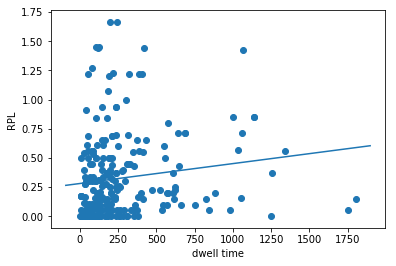

In [360]:
plt.scatter(dwell, rpl)
plt.xlabel("dwell time")
plt.ylabel("RPL")
axes = plt.gca()
m, b = np.polyfit(dwell, rpl, 1)
X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
plt.plot(X_plot, m*X_plot + b, '-')
plt.save()

In [325]:
[i for i, j in enumerate(rpl) if j != 0]

[0,
 1,
 3,
 7,
 8,
 9,
 10,
 13,
 14,
 20,
 22,
 24,
 28,
 31,
 32,
 33,
 34,
 37,
 38,
 39,
 40,
 42,
 44,
 49,
 51,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 62,
 63,
 65,
 67,
 69,
 70,
 71,
 72,
 75,
 76,
 77,
 79,
 82,
 83,
 84,
 86,
 88,
 91,
 92,
 93,
 94,
 95,
 99,
 100,
 101,
 102,
 103,
 105,
 106,
 107,
 109,
 112,
 113,
 114,
 117,
 119,
 120,
 121,
 122,
 124,
 125,
 127,
 129,
 131,
 133,
 136,
 137,
 141,
 143,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 155,
 157,
 162,
 164,
 165,
 166,
 167,
 169,
 171,
 172,
 174,
 175,
 176,
 177,
 179,
 181,
 182,
 186,
 187,
 188,
 193,
 196,
 197,
 203,
 204,
 205,
 207,
 214,
 215,
 216,
 217,
 218,
 220,
 222,
 223,
 225,
 226,
 228,
 230,
 231,
 232,
 233,
 235,
 237,
 238,
 239,
 241,
 243,
 244,
 245,
 246]

In [328]:
x = [dwell[k] for k in [i for i, j in enumerate(rpl) if j != 0] ]
y = [k for k in rpl if k!= 0]

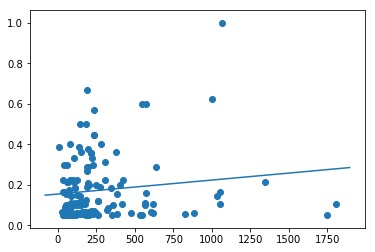

In [329]:
plt.scatter(x, y)
axes = plt.gca()
m, b = np.polyfit(x, y, 1)
X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
plt.plot(X_plot, m*X_plot + b, '-')

In [330]:
stats.spearmanr(x, y)

SpearmanrResult(correlation=0.11862771377366209, pvalue=0.16120230991351867)

In [397]:
rpl_high_dict = {0: [], 1:[],2:[],3:[],4:[]}
rpl_low_dict = {0: [], 1:[],2:[],3:[],4:[]}
for count, user in enumerate(highiq_users):
    print(count)
    rpl_high_dict[0].append(cum_absolute_learning_gain_fine(user)['0']/20)
    for i in range(1,5):
        if cum_absolute_learning_gain_fine(user)[str(i-1)] == 20:
            rpl_high_dict[i].append(1)
        else:
            rpl_high_dict[i].append((cum_absolute_learning_gain_fine(user)[str(i)]-cum_absolute_learning_gain_fine(user)[str(0)])/(20-(cum_absolute_learning_gain_fine(user)[str(0)])))
    
    
for count, user in enumerate(lowiq_users):
    print(count)
    rpl_low_dict[0].append(cum_absolute_learning_gain_fine(user)['0']/20)
    for i in range(1,5):
        if cum_absolute_learning_gain_fine(user)[str(i-1)] == 20:
            rpl_low_dict[i].append(1)
        else:
            rpl_low_dict[i].append((cum_absolute_learning_gain_fine(user)[str(i)]-cum_absolute_learning_gain_fine(user)[str(0)])/(20-(cum_absolute_learning_gain_fine(user)[str(0)])))
   
            

0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


<Figure size 480x320 with 0 Axes>

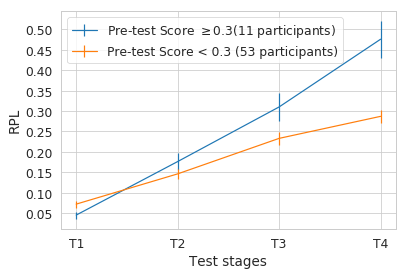

In [456]:
import seaborn as sns
import matplotlib.ticker as ticker


sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.4) 
from scipy import stats
plt.figure(figsize=(6, 4), dpi=80)
fig,ax = plt.subplots()
yerr_m = [stats.sem(rpl_high_dict[key])/2 for  key in np.sort([int(k) for k in rpl_high_dict.keys()])][1:5]
line1 = plt.errorbar(np.arange(4),[np.mean(rpl_high_dict[key]) for  key in np.sort([int(k) for k in rpl_high_dict.keys()])][1:5], yerr_m)
# plt.legend(loc='lower left', frameon=False)
plt.ylabel("ALG")
plt.xlabel("Search period")
plt.xticks(np.arange(4), ('T1', 'T2', 'T3', 'T4'))
plt.yticks(np.arange(0, 1, step=0.05))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
# plt.yticks(np.arange(0, 1, step=0.05))

# plt.title("Pre-test Score >= 3 (11 users)")


yerr_m = [stats.sem(rpl_low_dict[key])/(2) for  key in np.sort([int(k) for k in rpl_low_dict.keys()])][1:5]
line2 = plt.errorbar(np.arange(4),[np.mean(rpl_low_dict[key]) for  key in np.sort([int(k) for k in rpl_low_dict.keys()])][1:5], yerr_m)
# plt.legend(loc='lower left', frameon=False)
plt.ylabel("RPL")
plt.xlabel("Test stages")
plt.xticks(np.arange(4), ('T1', 'T2', 'T3', 'T4'))
plt.legend((line1,line2),("Pre-test Score $ \geq 0.3 $(11 participants)","Pre-test Score < 0.3 (53 participants)"))

# fig = line1.get_figure()
plt.savefig("output.pdf", bbox_inches="tight")

In [433]:
[np.mean(rpl_low_dict[key]) for  key in np.sort([int(k) for k in rpl_low_dict.keys()])][1:5]

[0.07215628941635133,
 0.1462160302717578,
 0.23312980162825364,
 0.28703417039330353]

In [382]:
cum_absolute_learning_gain_fine("5d26f5eb7aa0b0000138b4ba")

{'0': 11, '1': 11, '2': 13, '3': 15, '4': 15}

In [395]:
user = "5d26f5eb7aa0b0000138b4ba"
for i in range(1,5):
    print((cum_absolute_learning_gain_fine(user)[str(i)]-cum_absolute_learning_gain_fine(user)[str(0)])/(20-(cum_absolute_learning_gain_fine(user)[str(0)])))

0.0
0.222222222222
0.444444444444
0.444444444444


In [424]:
# rpl_dict = {'0': [], '1': [], '2': [], '3': [], '4':[] }
topic_wise_rpl = {k: {str(i):[] for i in range(5)} for k in np.arange(11)}
print(topic_wise_rpl)


for topic in range(1,11):
    c = 0
    for count, user in enumerate(users):
        topic_id = get_topic_id(user)
        if str(topic) == str(topic_id):
            c+=1
            for i in range(5):
#                 print(topic_wise_alg[topic][str(i)])
                topic_wise_rpl[topic][str(i)].append(rpl_dict[i][count])
    
    with open('topics.json') as json_file:
        data = json.load(json_file)
        print(data[str(topic)]['title'], "count=", c )

{0: {'1': [], '0': [], '3': [], '2': [], '4': []}, 1: {'1': [], '0': [], '3': [], '2': [], '4': []}, 2: {'1': [], '0': [], '3': [], '2': [], '4': []}, 3: {'1': [], '0': [], '3': [], '2': [], '4': []}, 4: {'1': [], '0': [], '3': [], '2': [], '4': []}, 5: {'1': [], '0': [], '3': [], '2': [], '4': []}, 6: {'1': [], '0': [], '3': [], '2': [], '4': []}, 7: {'1': [], '0': [], '3': [], '2': [], '4': []}, 8: {'1': [], '0': [], '3': [], '2': [], '4': []}, 9: {'1': [], '0': [], '3': [], '2': [], '4': []}, 10: {'1': [], '0': [], '3': [], '2': [], '4': []}}
(u'Radioactive decay', 'count=', 7)
(u'Qubit', 'count=', 5)
(u'Water quality chemistry', 'count=', 13)
(u'Religions', 'count=', 3)
(u'Sedimentary rocks', 'count=', 5)
(u'Anesthesia', 'count=', 7)
(u'Glycolysis', 'count=', 10)
(u'Urban water cycle', 'count=', 6)
(u'Depression', 'count=', 3)
(u'Industrial biotechnology', 'count=', 3)


In [524]:
for i in range(1,11):
    with open('topics.json') as json_file:
        data = json.load(json_file)
        print(i, data[str(i)]['title'])
    print(np.mean(topic_wise_rpl[i]['4']))

(1, u'Radioactive decay')
0.30178571428571427
(2, u'Qubit')
0.3066666666666667
(3, u'Water quality chemistry')
0.20358442726863782
(4, u'Religions')
0.18323586744639375
(5, u'Sedimentary rocks')
0.3287134502923976
(6, u'Anesthesia')
0.5480769230769231
(7, u'Glycolysis')
0.3710526315789474
(8, u'Urban water cycle')
0.2490253411306043
(9, u'Depression')
0.4741554741554741
(10, u'Industrial biotechnology')
0.3078703703703704


1
2
3
4
5
6
7
8
9
10


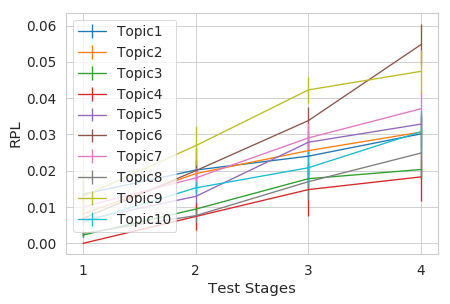

In [429]:
from scipy import stats
plt.figure(figsize=(6, 4), dpi=80)

for i in range(1,11):
    print(i)
    yerr_m = [stats.sem(topic_wise_rpl[i][str(key)])/(2*10) for  key in np.sort([int(k) for k in topic_wise_rpl[i].keys()])][1:5]
    line1 =   plt.errorbar(np.arange(4),[np.mean(topic_wise_rpl[i][str(key)])/10 for  key in np.sort([int(k) for k in topic_wise_rpl[i].keys()])][1:5], yerr_m, label ="Topic"+str(i))
    # plt.legend(loc='lower left', frameon=False)
    plt.ylabel("RPL")
    plt.xlabel("Test Stages")
    plt.xticks(np.arange(4), ('1', '2', '3', '4'))
    plt.legend(loc= "upper left")
#     plt.legend(str(i))
#     plt.title("Pre Test Score >= 3 (11 users)")
plt.savefig("RPLpertopic.pdf")

# yerr_m = [stats.sem(lowiq_cum_alg_dict[str(key)])/(2*10) for  key in np.sort([int(k) for k in lowiq_cum_alg_dict.keys()])][1:5]
# line2 = plt.errorbar(np.arange(4),[np.mean(lowiq_cum_alg_dict[str(key)])/10 for  key in np.sort([int(k) for k in lowiq_cum_alg_dict.keys()])][1:5], yerr_m)
# # plt.legend(loc='lower left', frameon=False)
# plt.ylabel("ALG")
# plt.xlabel("Search period")
# plt.xticks(np.arange(4), ('1', '2', '3', '4'))
# plt.legend((line1,line2),("Pre Test Score >= 3 (11 users)","Pre Test Score < 3 (53 users)"))